*  # Detecting Malaria : CNN et VGG16

Throughout this project, we are trying to detect infected and uninfected malaria cells using the CNN and the pre-trained VGG16 model.

### Importing libraries 

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers  import Conv2D, MaxPooling2D,Dense,BatchNormalization,Dropout
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import  optimizers
from keras import backend as K
print(os.listdir("../input/cell-images-for-detecting-malaria/cell_images/cell_images"))

['Uninfected', 'Parasitized']


### Loading the data

we can add a database of images by clicking on add data then we look for the name of dataset that we want to import on our notebook kaggle .

In [2]:
infected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/') 
uninfected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/')

### Data preprocessing

Now we are going to concatenate our dataset which is composed of two classes: infected and uninfected.Then each picture will be resized , reshaped and labeled 

In [3]:
data = []
labels = []

for i in infected:
    try:
        ## read the images and resize them 
        image = cv2.imread("../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        image = cv2.imread("../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')

##### Ploting images and its labels to understand how does an infected cell and uninfected cell looks like.

In [4]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [5]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (96453, 50, 50, 3) | labels : (96453,)


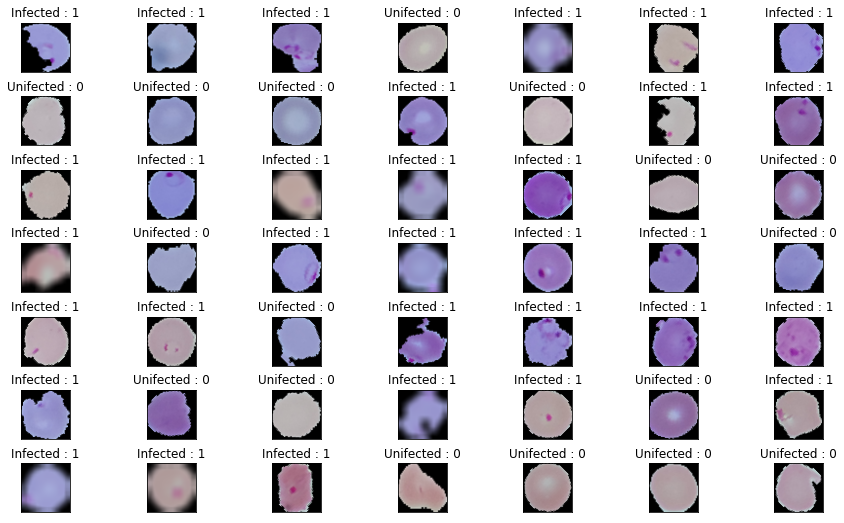

In [6]:
## make titles to our images : uninfected : 0 , Infected : 1
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

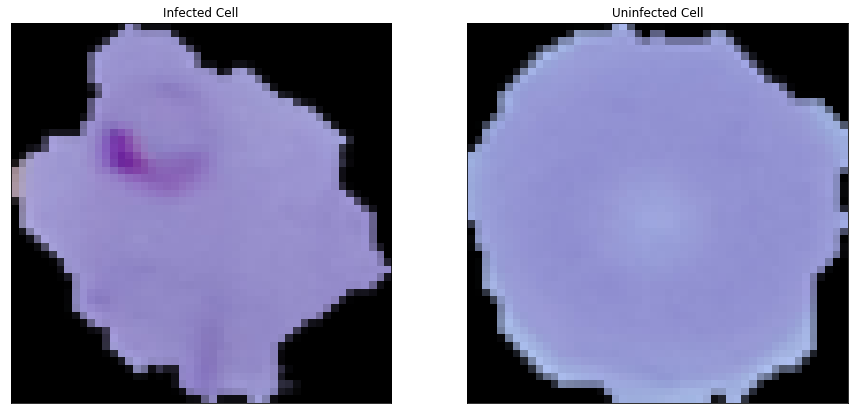

In [7]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[60000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [8]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]
## normalization of our images 
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

### Spliting data

In [9]:
from sklearn.model_selection import train_test_split
## Splitting the data in 80% Train , 10% validation  and 10% Test set.
X_train , X_test , y_train, y_test = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

val_x , test_x , val_y , test_y = train_test_split(X_test ,y_test , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

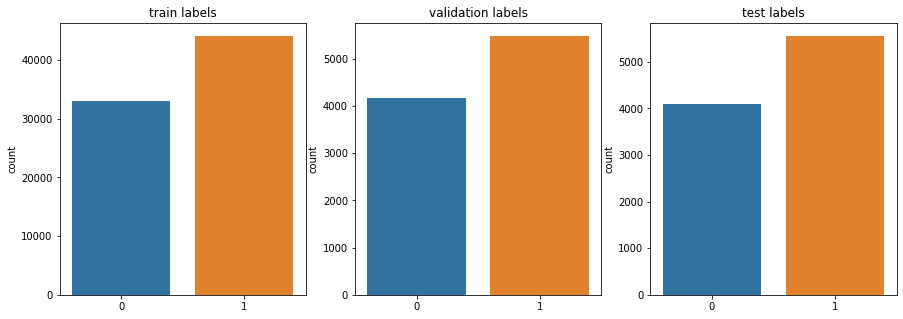

In [10]:
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([y_train , val_y , test_y] , ['train labels','validation labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [11]:
## see the shape of our training , validation and test data 
print('train data shape {} ,val data shape {} , test data shape {}'.format(X_train.shape,
                                                                           val_x.shape ,
                                                                           test_x.shape))

train data shape (77162, 50, 50, 3) ,val data shape (9645, 50, 50, 3) , test data shape (9646, 50, 50, 3)


### Creating a Convolution Neural Network CNN

In [12]:

model = Sequential()
model.add(keras.layers.Conv2D(32,(3,3),input_shape = (50,50,3),activation = 'relu'))
model.add(keras.layers.MaxPool2D(pool_size =(2,2),data_format ="channels_last"))

model.add(keras.layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(keras.layers.MaxPool2D(pool_size =(2,2),data_format ="channels_last"))

model.add(keras.layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(keras.layers.MaxPool2D(pool_size =(2,2),data_format ="channels_last"))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(activation = 'relu',units=512))
model.add(keras.layers.BatchNormalization(axis=-1))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(activation = 'sigmoid',units=1))

model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

### fitting the data

In [13]:
history = model.fit(X_train, 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 5,      
                         validation_data=(val_x,val_y),
                         shuffle = False
                     )

2021-12-18 00:28:37.068672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1206/1206 [==============================] - 86s 71ms/step - loss: 0.2276 - accuracy: 0.9117 - val_loss: 1.7543 - val_accuracy: 0.5686
Epoch 2/5
1206/1206 [==============================] - 85s 70ms/step - loss: 0.1554 - accuracy: 0.9473 - val_loss: 0.4204 - val_accuracy: 0.8086
Epoch 3/5
1206/1206 [==============================] - 85s 71ms/step - loss: 0.1425 - accuracy: 0.9528 - val_loss: 0.6145 - val_accuracy: 0.6961
Epoch 4/5
1206/1206 [==============================] - 84s 70ms/step - loss: 0.1356 - accuracy: 0.9539 - val_loss: 0.1317 - val_accuracy: 0.9591
Epoch 5/5
1206/1206 [==============================] - 86s 71ms/step - loss: 0.1303 - accuracy: 0.9561 - val_loss: 0.1200 - val_accuracy: 0.9627


##### Evaluating data

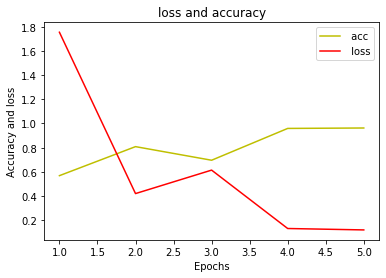

In [14]:
#plot the training and validation accuracy and loss at each epoch
acc = history.history['val_accuracy']##getting  accuracy of each epochs
loss = history.history['val_loss']##getting validation accuracy of each epochs
plt.plot([1,2,3,4,5], acc, 'y', label=' acc')
plt.plot([1,2,3,4,5], loss, 'r', label=' loss')
plt.title('loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and loss')
plt.legend()
plt.show()

### Predicting on Test data

The prediction for this image is:  [[0.97755104]]
The actual label for this image is:  1


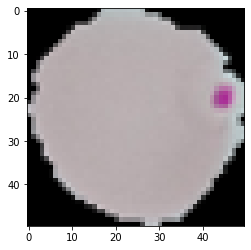

In [15]:
## Ploting the predicted image and its respective True value and predicted value.
n=3  #Select the index of image to be loaded for testing
img = test_x[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", test_y[n])

### the performance of the model

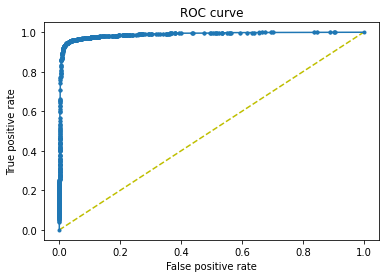

In [16]:
#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(test_x).ravel()

fpr, tpr, thresholds = roc_curve(test_y, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()


In [17]:
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 


from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)


Ideal threshold is:  702    0.516795
Name: thresholds, dtype: float32
Area under curve, AUC =  0.9884636989208538


## Improving our model using VGG16

In [18]:
from keras.applications.vgg16 import VGG16
file='/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model=VGG16(input_shape = (50, 50, 3), 
                        include_top = False, 
                        weights =None)
pretrained_model.load_weights(file)

for layer in pretrained_model.layers:
     layer.trainable = False

last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(10, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
x = keras.layers.Dense(1, activation='softmax')(x)           

model_vgg = keras.Model(pretrained_model.input, x) 

last layer of vgg : output shape:  (None, 1, 1, 512)


In [19]:
model_vgg.compile(optimizer = 'adam', loss='binary_crossentropy',metrics = ['accuracy'])
print(model_vgg.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [20]:
model_vgg.fit(X_train,y_train,epochs=1,validation_data=(val_x,val_y))

2412/2412 [==============================] - 996s 413ms/step - loss: 0.3492 - accuracy: 0.5713 - val_loss: 0.2471 - val_accuracy: 0.5686


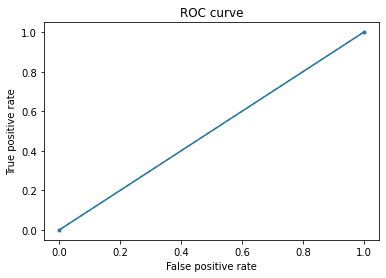

In [21]:
#ROC_vgg16
from sklearn.metrics import roc_curve
y_preds_vgg = model_vgg.predict(test_x).ravel()

fpr, tpr, thresholds = roc_curve(test_y,y_preds_vgg)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

The prediction for this image is:  [[1.]]
The actual label for this image is:  1


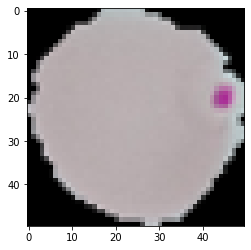

In [22]:
## Ploting the predicted image and its respective True value and predicted value.
n=3  #Select the index of image to be loaded for testing
img = test_x[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model_vgg.predict(input_img))
print("The actual label for this image is: ", test_y[n])